In [1]:
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import os
import torch.optim as optim
from probe_experiment import ProbeExperiment

In [2]:
with open('data/annotations_with_at_least_one_top10_kw.pkl', 'rb') as file:
    annotations = pkl.load(file)
annotations.sort(key = lambda ant : ant['f_name'])

In [3]:
from probe_dataset import *
split = 0.8
annotations.sort(key = lambda ant : ant['f_name'])
train_ants = annotations[:int(len(annotations)*split)]
test_ants = annotations[int(len(annotations)*split):]

keywords = ['territory', 'cut', 'sente', 'shape', 'moyo',
            'ko', 'invasion', 'influence', 'wall', 'eye']
train_dataset = SPBoWDataset(train_ants, keywords)
test_dataset = SPBoWDataset(test_ants, keywords)

train_dataset = load_to_memory(train_dataset)
test_dataset = load_to_memory(test_dataset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15842/15842 [00:21<00:00, 752.67it/s]


### Go Model

In [4]:
from models import *
go_model = load_go_model_from_ckpt('model_ckpt.pth.tar', rm_prefix=True)
feat_model = CutModel(go_model, 7).cuda()

### Probe Model

In [10]:
linear_probe = nn.Linear(11552, len(keywords)).cuda() 
probe_model = linear_probe

### Training

In [11]:
exp = ProbeExperiment(train_dataset, test_dataset, keywords)
lr = 0.001
criterion = nn.BCEWithLogitsLoss()
config = {'num_epochs':4, 'batch_size':512,
               'criterion':criterion,
               'optimizer':optim.Adam(probe_model.parameters(), lr=lr),
               'write_log':True, 'save_ckpt':False}
exp.run('linear_probe_rm_neg_%f' % lr, feat_model, probe_model, config)

[LOG] epoch 0 loss 0.316226, new best
[LOG] epoch 1 loss 0.315542, new best
[LOG] epoch 2 loss 0.315989
[LOG] epoch 3 loss 0.317128


### Probe Evaluation

In [12]:
preds, labels = exp.predict_labels(feat_model, probe_model, test_dataset)

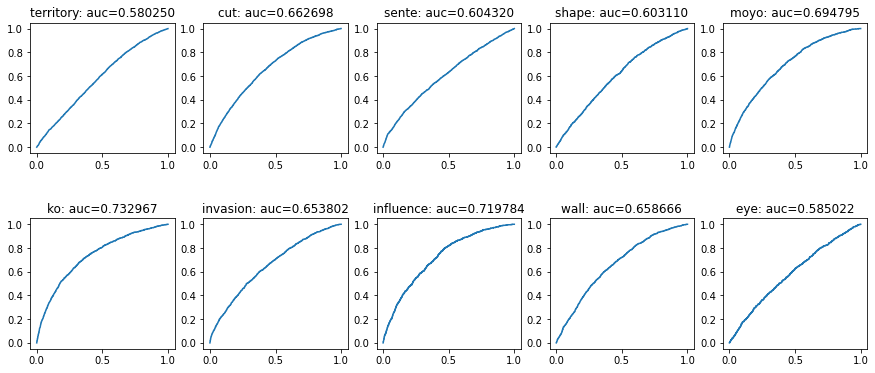

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from math import ceil

cols = 5
rows = ceil(len(keywords)/cols)
plt.rcParams['figure.figsize'] = (3*cols, 3*rows)
fig, axs = plt.subplots(rows, cols)
fig.subplots_adjust(hspace=0.5)

for kw in range(len(keywords)):
    kw_preds, kw_labels = preds[:,kw], labels[:,kw]
    fprs, tprs, _ = roc_curve(kw_labels, kw_preds)
    auc = roc_auc_score(kw_labels, kw_preds)
    axs[kw//cols][kw%cols].plot(fprs, tprs)
    axs[kw//cols][kw%cols].set_title('%s: auc=%f' % (keywords[kw], auc))
    
plt.show()